# Forecasting 

Let's examine the SAAS data similarly to what we did with Store Data.
- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle 

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#### Acquire Data (SAAS)

In [3]:
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
print('shape:', df.shape)
df.head()

shape: (790458, 5)


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


## Data Prep

In [5]:
# Lowercase column names
df.columns = [col.lower() for col in df]
# Properly parse the datetime field
df.month_invoiced = pd.to_datetime(df.month_invoiced)

I suspect subscription type and amount are integers, let's confirm and then convert to the right data types.

In [6]:
df.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

In [7]:
df.subscription_type = df.subscription_type.astype(int)

In [8]:
df.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [9]:
df.amount = df.amount.astype(int)

In [10]:
# a datetime index is probably a good idea for time series analysis
df = df.set_index('month_invoiced')

## Data Wrangling

Trying to get my head around what the data set means.

What's invoice id?

In [11]:
print('rows:', df.shape[0])
print('unique invoice ids:', df.invoice_id.nunique())

rows: 790458
unique invoice ids: 790458


Looks like invoice id does uniquely identify a row. We probably won't use this much.

Are subscription types and amounts related? Probably, but let's confirm

In [12]:
pd.crosstab(df.subscription_type, df.amount)

amount,0,5,10,15,20
subscription_type,,,,,
0,496410,0,0,0,0
1,0,178212,0,0,0
2,0,0,70706,0,0
3,0,0,0,26474,0
4,0,0,0,0,18656


Yes, it looks like there's only one combination of subscription type and amount. So, for example, if a cusomter is on subscription type 2, we know they pay $10 a month.

It also looks like we have 4 paid plans (subscription type 1-4) and a free tier (subscription type == 0).

How many unique customers are there?

In [22]:
df.customer_id.nunique()

29400

How many observations are there each month?

Text(0.5, 1.0, 'How many observations are there each month?')

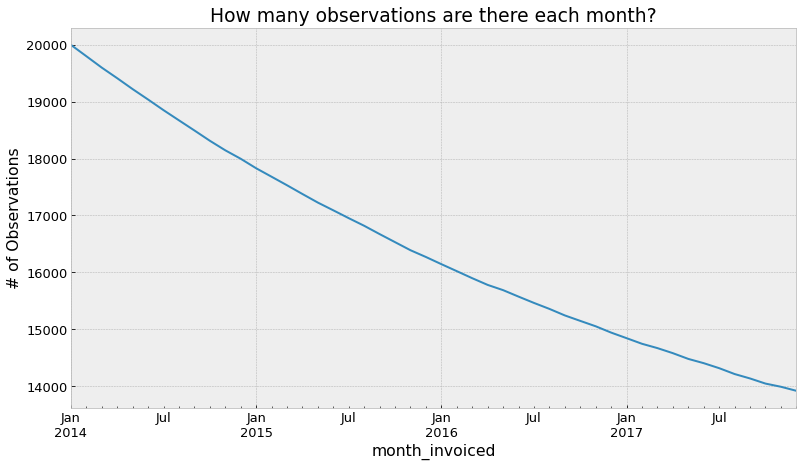

In [23]:
df.resample('M').size().plot()
plt.ylabel('# of Observations')
plt.title('How many observations are there each month?')

Interesting, it looks like there are less observations each month as time goes on. Does this mean we are losing customers?

## Visualize

Let's start by looking at monthly revenue over time.

[Text(0.5, 1.0, 'Revenue Over time'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, '')]

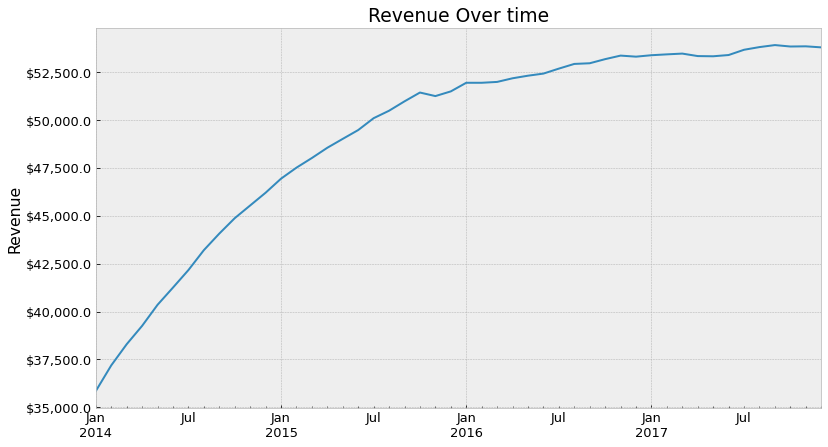

In [14]:
ax = df.resample('M').amount.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
ax.set(title='Revenue Over time', ylabel='Revenue', xlabel='')


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

# Let's focus on making a simple projection based on revenue by month

In [30]:
df = df.resample('M')[['amount']].sum()

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [31]:
int(len(df) * 0.5)

24

In [32]:
# set train size to be 50% of total 
train_size = int(len(df) * 0.5)
train_size

24

In [33]:
# set validate size to be 30% of total 
validate_size = int(len(df) * 0.3)
validate_size

14

In [34]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

10

In [35]:
len(df) == train_size + validate_size + test_size

True

In [36]:
# set end for validate
validate_end_index = train_size + validate_size
validate_end_index

38

Use those values to split our dataframe

In [37]:
# train will go from 0 to 23
train = df[:train_size]

In [38]:
# validate will go from 24 to 37
validate = df[train_size:validate_end_index]

In [39]:
validate

,amount
month_invoiced,
2016-01-31,51955
2016-02-29,51955
2016-03-31,52000
2016-04-30,52190
2016-05-31,52325
2016-06-30,52435
2016-07-31,52695
2016-08-31,52940
2016-09-30,52975


In [40]:
# test will include 38 to the end
test = df[validate_end_index:]

In [41]:
train.size, validate.size, test.size

(24, 14, 10)

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [42]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df)

True

Does the first row of original df equate to the first row of train? 

In [43]:
print(df.head(1) == train.head(1))

                amount
month_invoiced        
2014-01-31        True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [44]:
pd.concat([train.tail(1), validate.head(1)])

,amount
month_invoiced,
2015-12-31,51505
2016-01-31,51955


In [45]:
pd.concat([validate.tail(1), test.head(1)])

,amount
month_invoiced,
2017-02-28,53440
2017-03-31,53480


Is the last row of test the same as the last row of our original dataframe? 

In [46]:
pd.concat([test.tail(1), df.tail(1)])

,amount
month_invoiced,
2017-12-31,53805
2017-12-31,53805


Let's plot our data first, viewing where the data is split into train and test. 

In [47]:
train.columns

Index(['amount'], dtype='object')

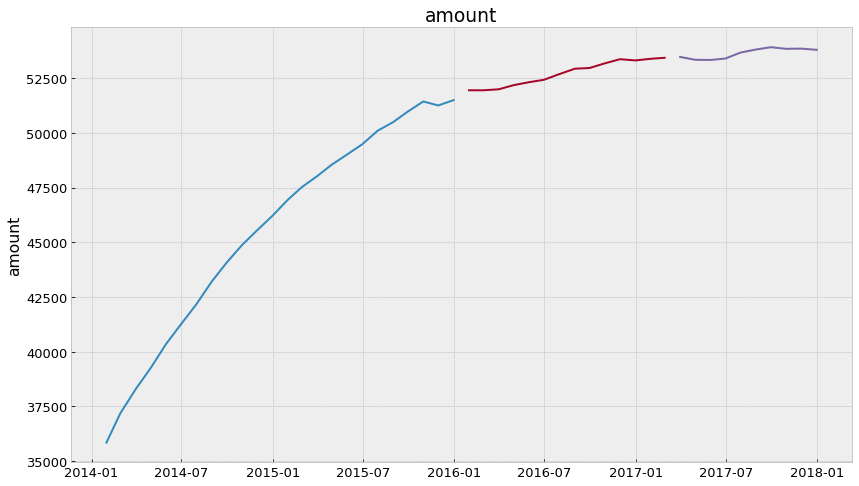

In [48]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [49]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [50]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [51]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [52]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Dollars

In [54]:
train['amount'][-1:][0]

51505

In [58]:
# take the last item of amount and assign to variable
amount = train['amount'][-1:][0]
amount

51505

Items

In [62]:
yhat_df = pd.DataFrame(
    {'amount': [amount]},
    index=validate.index)

yhat_df.head()

,amount
month_invoiced,
2016-01-31,51505
2016-02-29,51505
2016-03-31,51505
2016-04-30,51505
2016-05-31,51505


In [63]:
yhat_df.describe()

,amount
count,14.0
mean,51505.0
std,0.0
min,51505.0
25%,51505.0
50%,51505.0
75%,51505.0
max,51505.0


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

amount -- RMSE: 1343


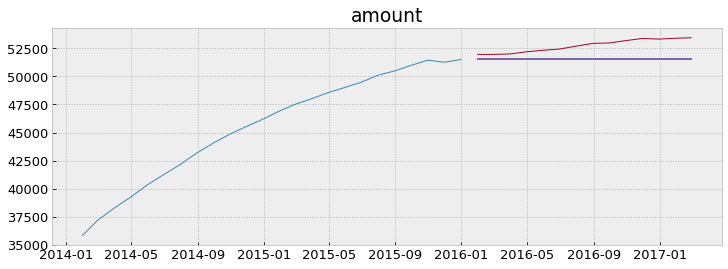

In [64]:
plot_and_eval('amount')

amount -- RMSE: 1343


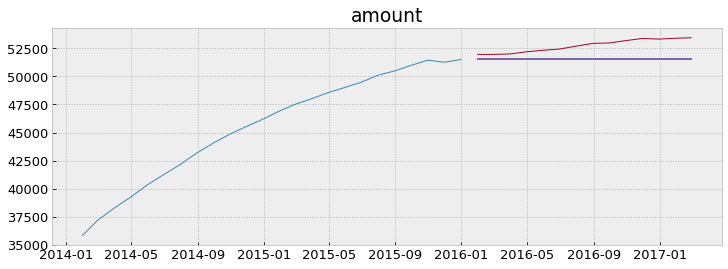

In [65]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [66]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

Dollars: establishing the value of the prediction we will make

In [68]:
# compute simple average
amount = round(train['amount'].mean(), 2)
amount

45568.54

Items: establishing the value of the prediction we will make

Apply predictions to our observations

In [71]:
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]},
                          index=validate.index)
    return yhat_df

In [73]:
yhat_df = make_predictions(amount)

In [74]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


In [75]:
yhat_df.describe()

,amount
count,1.400000e+01
mean,4.556854e+04
std,7.550618e-12
min,4.556854e+04
25%,4.556854e+04
50%,4.556854e+04
75%,4.556854e+04
max,4.556854e+04


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

amount -- RMSE: 7181


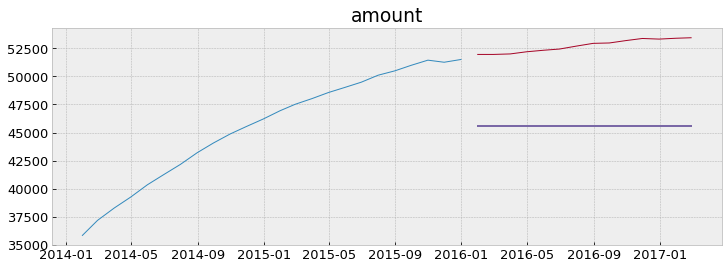

In [76]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [77]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0


### Moving Average

In this example, we will use a ~90-day (3 month) moving average to forecast. In other words, the average over the last 90-days will be used as the forecasted value. 

In [81]:
print(train['amount'].rolling(3).mean())


month_invoiced
2014-01-31             NaN
2014-02-28             NaN
2014-03-31    37111.666667
2014-04-30    38246.666667
2014-05-31    39301.666667
2014-06-30    40288.333333
2014-07-31    41260.000000
2014-08-31    42211.666667
2014-09-30    43151.666667
2014-10-31    44055.000000
2014-11-30    44833.333333
2014-12-31    45545.000000
2015-01-31    46233.333333
2015-02-28    46891.666667
2015-03-31    47496.666667
2015-04-30    48035.000000
2015-05-31    48536.666667
2015-06-30    49023.333333
2015-07-31    49538.333333
2015-08-31    50028.333333
2015-09-30    50528.333333
2015-10-31    50975.000000
2015-11-30    51230.000000
2015-12-31    51403.333333
Freq: M, Name: amount, dtype: float64


**Make Predictions**

In [83]:
period=3
train['amount'].rolling(period).mean()[-1]

51403.333333333336

In [84]:
period = 3

# take 90 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
amount = round(train['amount'].rolling(period).mean()[-1], 2)
print(amount)

51403.33


In [85]:
yhat_df = make_predictions(amount)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

amount -- RMSE: 1436


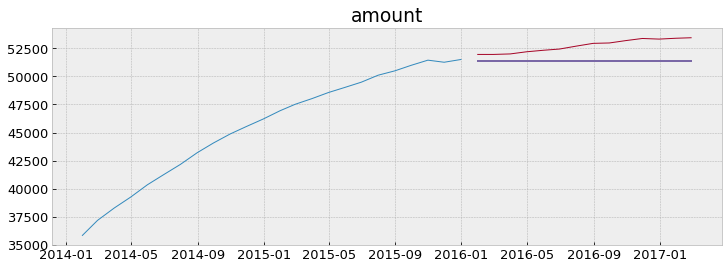

In [86]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [87]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '3_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,3_month_moving_avg,amount,1436.0


Let's try out several other values for periods:

In [88]:
periods = [1, 2, 3, 4, 10]

for p in periods: 
    amount = round(train['amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(amount)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [89]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,3_month_moving_avg,amount,1436.0
3,1_month_moving_avg,amount,1343.0
4,2_month_moving_avg,amount,1455.0
5,3_month_moving_avg,amount,1436.0
6,4_month_moving_avg,amount,1533.0
7,10_month_moving_avg,amount,2696.0


Which is best so far? 

In [91]:
min_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()

In [92]:
min_rmse

1343.0

In [93]:
eval_df[eval_df.rmse == min_rmse]

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0


In [94]:
# (these are the same due to the nature of the aggregation ^^)

### Holt's Linear Trend


Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**


First, let's take a look at the seasonal decomposition for each target. 

In [95]:
import statsmodels.api as sm

amount 



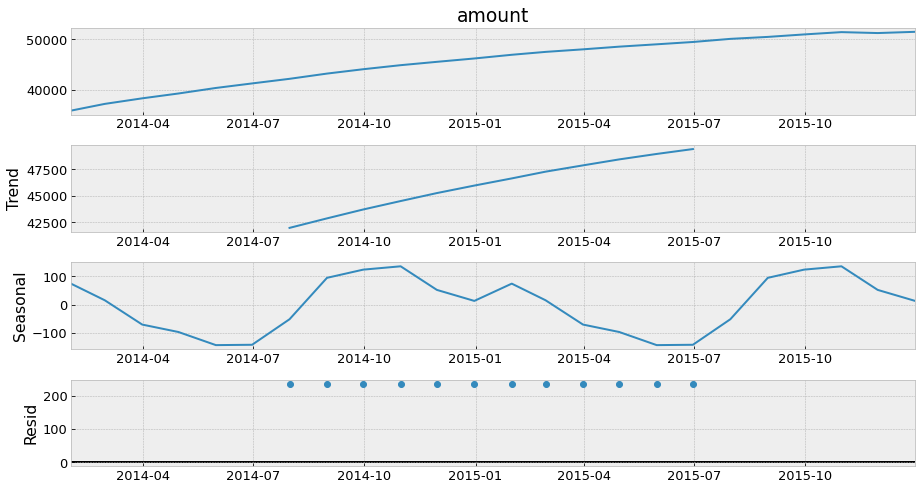

In [97]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [99]:
train.columns

Index(['amount'], dtype='object')

In [100]:
col = 'amount' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [101]:
# fit the holt's object
model = model.fit(optimized=True)

In [102]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [103]:
validate.shape

(14, 1)

In [104]:
yhat_items

2016-01-31    51748.617355
2016-02-29    51961.994955
2016-03-31    52173.345472
2016-04-30    52382.688161
2016-05-31    52590.042098
2016-06-30    52795.426176
2016-07-31    52998.859109
2016-08-31    53200.359431
2016-09-30    53399.945504
2016-10-31    53597.635512
2016-11-30    53793.447468
2016-12-31    53987.399213
2017-01-31    54179.508420
2017-02-28    54369.792592
Freq: M, dtype: float64

In [105]:
yhat_df[col] = round(yhat_items, 2)

In [106]:
yhat_df

,amount
month_invoiced,
2016-01-31,51748.62
2016-02-29,51961.99
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04
2016-06-30,52795.43
2016-07-31,52998.86
2016-08-31,53200.36
2016-09-30,53399.95


**Plot Actual vs. Predicted Values**

amount -- RMSE: 456


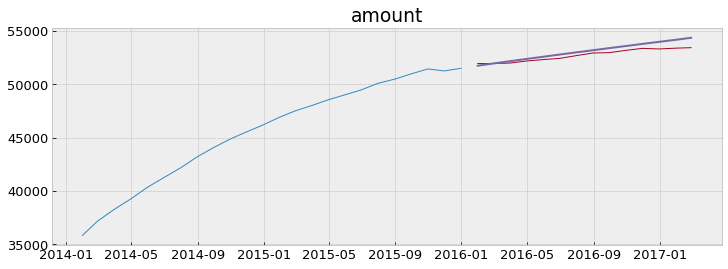

In [109]:
plot_and_eval(target_var = col)

**Evaluate**

In [110]:
eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [111]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
8,holts_optimized,amount,456.0
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0
2,3_month_moving_avg,amount,1436.0
5,3_month_moving_avg,amount,1436.0
4,2_month_moving_avg,amount,1455.0
6,4_month_moving_avg,amount,1533.0
7,10_month_moving_avg,amount,2696.0
1,simple_average,amount,7181.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [112]:
df.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='month_invoiced', freq='M')

In [114]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(24, 1)
(12, 1)
(12, 1)


,amount
month_invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


**Make Predictions**

In [115]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2015'] + train.diff(12).mean()

Back to predictions

In [118]:
train.loc['2015'].head()

,amount
month_invoiced,
2015-01-31,46945
2015-02-28,47520
2015-03-31,48025
2015-04-30,48560
2015-05-31,49025


In [105]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-01-01,104337.620493,19411.813699
2015-01-02,112870.770493,20904.813699
2015-01-03,118245.300493,21983.813699
2015-01-04,125496.760493,23286.813699
2015-01-05,88551.940493,16420.813699


In [119]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,amount
month_invoiced,
2015-01-31,55033.75
2016-01-31,51955.00


In [120]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [121]:
yhat_df.describe()

,amount
count,12.000000
mean,57701.666667
std,1596.656248
min,55033.750000
25%,56515.000000
50%,57883.750000
75%,59142.500000
max,59593.750000


In [122]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,55033.75
2016-02-29,55608.75
2016-03-31,56113.75
2016-04-30,56648.75
2016-05-31,57113.75


In [123]:
yhat_df.shape

(12, 1)

**Plot and Evaluate**

amount -- RMSE: 5192


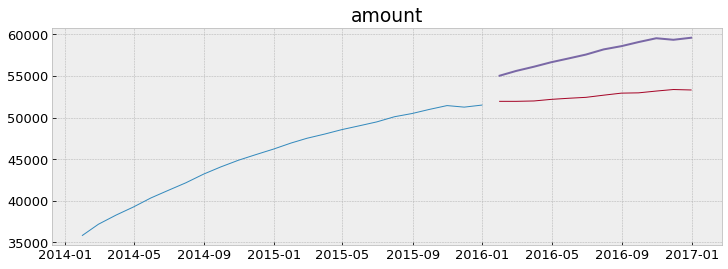

In [124]:
plot_and_eval(target_var = col)
eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

## Conclusion

Which model did the best? 

In [130]:
min_rmse = eval_df['rmse'].min()

In [131]:
# find which model that is
eval_df[(eval_df.rmse == min_rmse)]

,model_type,target_var,rmse
8,holts_optimized,amount,456.0


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [132]:
yhat_items = model.predict(start = test.index[0],
                              end = test.index[-1])

In [133]:
yhat_df = pd.DataFrame(index=test.index, columns=test.columns)
yhat_df.amount = yhat_items

In [134]:
yhat_df

,amount
month_invoiced,
2017-01-31,54179.508420
2017-02-28,54369.792592
2017-03-31,54558.269068
2017-04-30,54744.955020
2017-05-31,54929.867458
2017-06-30,55113.023231
2017-07-31,55294.439027
2017-08-31,55474.131375
2017-09-30,55652.116649


In [135]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [137]:
rmse_amount = sqrt(mean_squared_error(test['amount'], 
                                       yhat_df['amount']))

In [138]:
print('rmse-amount: ', rmse_amount)

rmse-amount:  1645.3809189368774


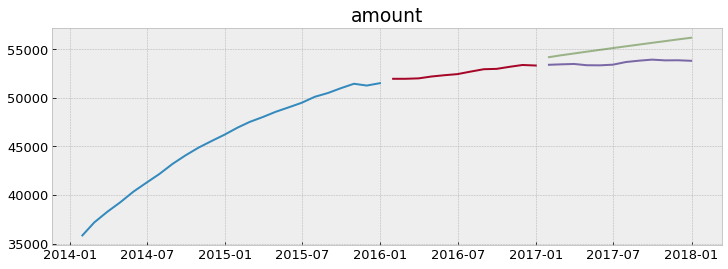

In [139]:
final_plot(col)

In [140]:
# to predict 2018
yhat_df.index = test.index + pd.Timedelta('1Y')

In [142]:
yhat = model.predict(start = test.index[0],
                              end = test.index[-1])

In [151]:
yhat

2017-01-31    54179.508420
2017-02-28    54369.792592
2017-03-31    54558.269068
2017-04-30    54744.955020
2017-05-31    54929.867458
2017-06-30    55113.023231
2017-07-31    55294.439027
2017-08-31    55474.131375
2017-09-30    55652.116649
2017-10-31    55828.411066
2017-11-30    56003.030688
2017-12-31    56175.991427
Freq: M, dtype: float64

In [152]:
yhat_df.amount = yhat.values

In [155]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='projection')
    plt.title(target_var)
    plt.legend()
    plt.show()

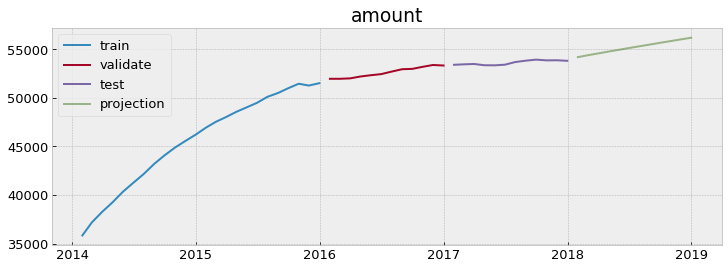

In [156]:
for col in train.columns:
    final_plot(col)